In [3]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os as os
import nrrd as reader
from sklearn.preprocessing import Normalizer
import cv2 as cv 


In [4]:
def join(one, two):
    return os.path.join(one, two)

In [5]:
def check_path(path):
    count=0
    for files in sorted(os.listdir(path)):
        image_path = os.path.join(path,files)
        count+=1
    return count

In [6]:
# (patient count* 15) check_path function will return total patient count 
folder_path = join(os.getcwd(), "Incoming Annotations")

length = check_path(folder_path)
inputs = np.zeros((length*15,256,256, 1))
outputs = np.zeros((length*15,256,256 , 9))

In [7]:
def dcm_to_np(path):
    global dic_count
    try:
        slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path)
        image = sitk.ReadImage(slice_filenames)
        for x in range(15):
            current_slice = image[:, :, x]
            current_array = sitk.GetArrayFromImage(current_slice)
            split_array = current_array[:,:-256]
            inputs[dic_count] = split_array[:, :, np.newaxis]
            dic_count+=1
        print(dic_count)
    except Exception as e:
        print(e)
#         print("Problem with this folder -> " + path)

In [8]:
def nrrd_to_np(meta_object):
    global ann_count
    try:
        data = sitk.GetArrayFromImage(meta_object)
        for p in range(15):
            current_seg = data[p, :, :]
            half_seg= current_seg[:,:-256]
            black = np.zeros([256, 256, 9])
            for y, a in enumerate(half_seg):
                for x, b in enumerate(a):
                    if b>0:
                        black[y][x][b-1] = 1
            outputs[ann_count] = black
            ann_count+=1
        print(ann_count)
    except Exception as e:
        print(e)

In [9]:
dic_count = 0
ann_count = 0

try:
    for patient in sorted(os.listdir(folder_path)):
            patient_path = join(folder_path, patient)
            nrrd_folder = join(patient_path, "NRRD")
            dcm_to_np(patient_path)
            for nrrd in os.listdir(nrrd_folder):
                if(".nrrd" in nrrd):
                    segmentation = sitk.ReadImage(join(nrrd_folder, nrrd))
                    nrrd_to_np(segmentation)
except Exception as e:
    print(e)

15
15
30
30
45
45
60
60
75
75
90
90
105
105
120
120
135
135
150
150
165
165
180
180
195
195
210
210
225
225
240
240
255
255
270
270
285
285
300
300
315
315
330
330
345
345
360
360
375
375
390
390
405
405
420
420
435
435
450
450
465
465
480
480
495
495
510
510
525
525
540
540
555
555
570
570
585
585
600
600
615
615
630
630
645
645
660
660
675
675
690
690
705
705
720
720
735
735
750
750
765
765
780
780
795
795
810
810
825
825
840
840
855
855
870
870
885
885
900
900
915
915
930
930
945
945
960
960
975
975
990
990
1005
1005
1020
1020
1035
1035
1050
1050
1065
1065
1080
1080
1095
1095
1110
1110
1125
1125
1140
1140
1155
1155
1170
1170
1185
1185
1200
1200
1215
1215
1230
1230
1245
1245
1260
1260
1275
1275
1290
1290
1305
1305
1320
1320
1335
1335
1350
1350
1365
1365
1380
1380
1395
1395
1410
1410
1425
1425
1440
1440
1455
1455
1470
1470
1485
1485
1500
1500
1515
1515
1530
1530
1545
1545
1560
1560
1575
1575
1590
1590
1605
1605
1620
1620
1635
1635
1650
1650
1665
1665
1680
1680
1695
1695
1710
1710
1725

In [8]:
# Normalization with sklearn 
# for x in range (1754):    
#     temp = inputs[x].reshape(256, 256)
#     transformer = Normalizer().fit(temp)
#     temp1 = transformer.transform(temp)
#     inputs[x]=temp1[:, :, np.newaxis]

In [16]:
#opencv + numpy normalization 
for x in range (1754):    
    temp = inputs[x].reshape(256, 256)
    temp1=cv.normalize(src=temp, dst=None, alpha=0.0, beta=255.0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    np.linalg.norm(temp1)
    inputs[x]=temp1[:, :, np.newaxis]

In [13]:
temp = inputs[1].reshape(256,256)
temp.max()


255.0

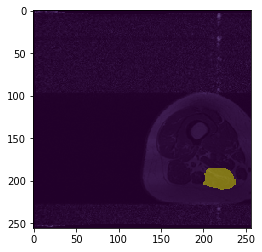

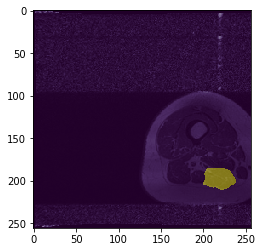

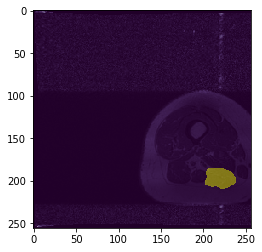

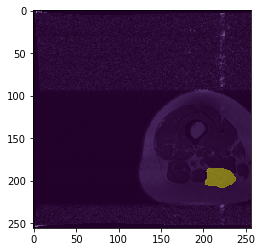

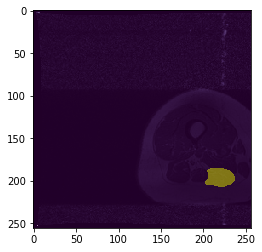

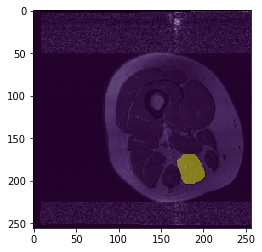

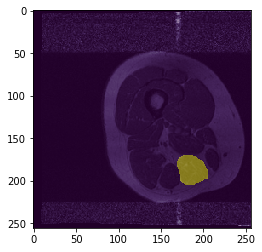

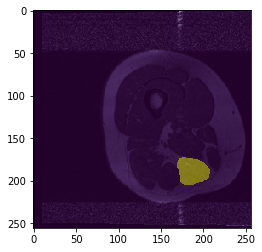

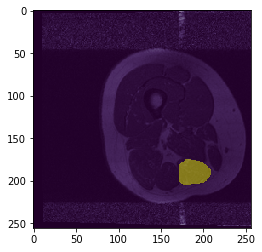

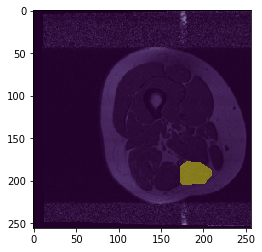

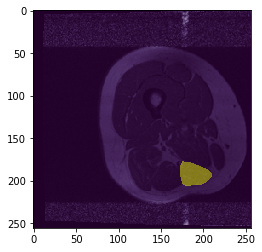

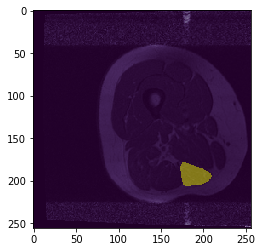

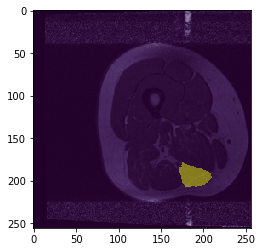

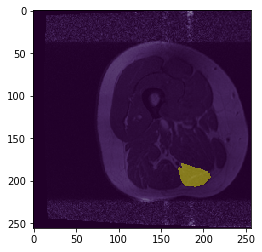

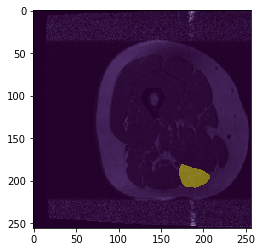

In [17]:
for i in range(1600, 1615):
    plt.imshow(inputs[i].reshape(256, 256), cmap=plt.cm.bone)
    plt.imshow(outputs[i][:, :, 8], alpha=0.5)
    plt.show()

In [18]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def unet_model(im_height, im_width, im_chan):

    input_img = Input((im_height, im_width, im_chan,), name='img')

    inp = BatchNormalization()(input_img)

    c1 = Conv2D(4, (3, 3), activation='relu', padding='same') (inp)
    a1 = MaxPooling2D((2, 2))(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(4, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    cat1 = concatenate([p1, a1])

    c2 = Conv2D(8, (3, 3), activation='relu', padding='same') (cat1)
    a2 = MaxPooling2D((2, 2))(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(8, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    cat2 = concatenate([p2, a2])

    c3 = Conv2D(16, (3, 3), activation='relu', padding='same') (cat2)
    a3 = MaxPooling2D((2, 2))(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(16, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    cat3 = concatenate([p3, a3])

    c4 = Conv2D(32, (3, 3), activation='relu', padding='same') (cat3)
    a4 = MaxPooling2D((2, 2))(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2)) (c4)

    cat4 = concatenate([p4, a4])

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (cat4)
    a5 = MaxPooling2D((2, 2))(c5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2)) (c5)

    cat5 = concatenate([p5, a5])

    c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (cat5)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

    u10 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(8, (3, 3), activation='relu', padding='same') (u10)
    c10 = Dropout(0.2)(c10)
    c10 = Conv2D(8, (3, 3), activation='relu', padding='same') (c10)

    u11 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (c10)
    u11 = concatenate([u11, c1], axis = 3)
    c11 = Conv2D(4, (3, 3), activation='relu', padding='same') (u11)
    c11 = Dropout(0.2)(c11)
    c11 = Conv2D(4, (3, 3), activation='relu', padding='same') (c11)

    outputs = Conv2D(9, (1, 1), activation='softmax') (c11)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model
model = unet_model(256, 256, 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 1)  4           img[0][0]                        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 4)  40          batch_normalization[0][0]        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 4)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [19]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
results = model.fit(x=inputs, y=outputs, epochs=20, batch_size=8)

Epoch 1/20
1755/1755 [==============================] - 23s 13ms/step - loss: 1.1716 - acc: 0.9828
Epoch 2/20
1755/1755 [==============================] - 17s 10ms/step - loss: 0.9981 - acc: 0.9902
Epoch 3/20
1755/1755 [==============================] - 17s 10ms/step - loss: 0.9621 - acc: 0.9913
Epoch 4/20
1755/1755 [==============================] - 17s 10ms/step - loss: 0.9385 - acc: 0.9919
Epoch 5/20
1755/1755 [==============================] - 17s 10ms/step - loss: 0.9136 - acc: 0.9926
Epoch 6/20
1755/1755 [==============================] - 18s 10ms/step - loss: 0.8934 - acc: 0.9933
Epoch 7/20
1755/1755 [==============================] - 18s 10ms/step - loss: 0.8698 - acc: 0.9948
Epoch 8/20
1755/1755 [==============================] - 18s 10ms/step - loss: 0.8575 - acc: 0.9955
Epoch 9/20
1755/1755 [==============================] - 18s 10ms/step - loss: 0.8502 - acc: 0.9959
Epoch 10/20
1755/1755 [==============================] - 18s 10ms/step - loss: 0.8416 - acc: 0.9963
Epoch 11/

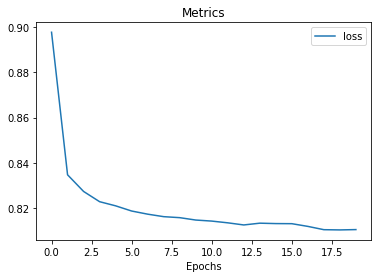

In [15]:
plt.title("Metrics")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.legend()

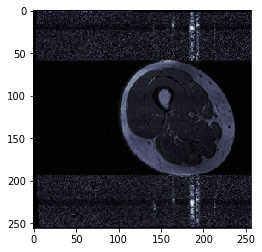

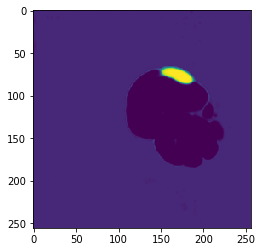

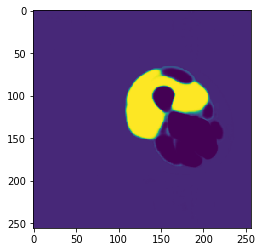

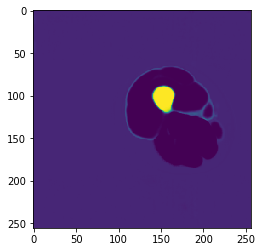

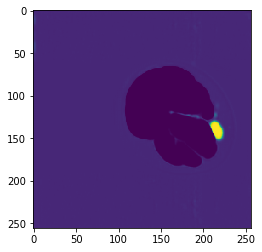

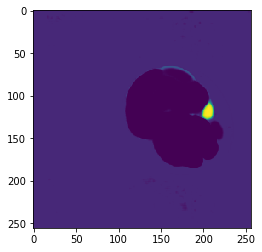

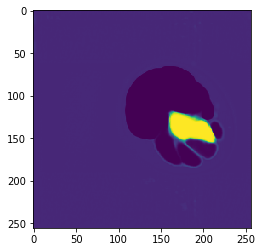

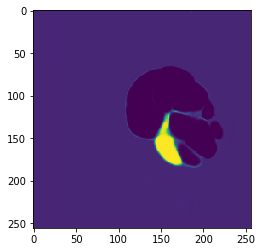

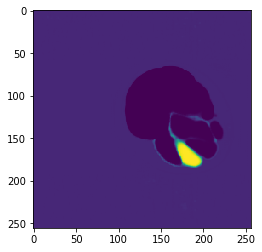

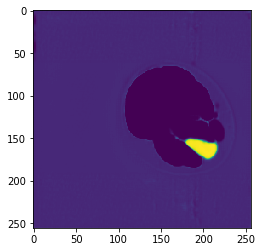

In [20]:
result = model.predict(inputs[100].reshape(1, 256, 256, 1))
plt.imshow(inputs[100].reshape(256, 256), cmap=plt.cm.bone)
plt.show()
for x in range(9):
    plt.imshow(result[0][:, :, x])
    plt.show()